In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import censusdata
import geopandas as gp
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 5]

In [2]:
# Download Census block boundaries for Chicago 
census_gdf = gp.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf.head(2)

,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10,geometry
0,17,Block 2010,2010,6903002010,170316903002010,690300,031,"MULTIPOLYGON (((-87.62907 41.76909, -87.62905 ..."
1,17,Block 3007,3007,6809003007,170316809003007,680900,031,"MULTIPOLYGON (((-87.63412 41.77447, -87.63410 ..."


In [3]:
# Useful for finding the ACS tables you want 
# censusdata.search('acs5', 2018, 'label', 'broadband') 
# censusdata.printtable(censusdata.censustable('acs5', 2018, 'B28011'))

# Pull ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B02001_001E': 'Total Pop', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income',
    'B03003_003E': 'Hispanic'}

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))

# Rename columns 
acs_df.rename(columns=census_tables, inplace=True)

print(acs_df.shape)
acs_df.head(2)

(3993, 6)


,GEO_ID,Total Pop,White,Black,Median Income,Hispanic
"Block Group 1, Census Tract 2713, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:271300> block group:1",1500000US170312713001,1316,0,1304,24340,0
"Block Group 3, Census Tract 2415, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:241500> block group:3",1500000US170312415003,826,705,37,132708,99


In [4]:
# convert acs_df to geo12 
acs_df['geo_12'] = acs_df["GEO_ID"].map(lambda x: str(x)[-12:])
census_gdf['geo_12'] = census_gdf["geoid10"].map(lambda x: str(x)[:12])

In [5]:
# Dissolve census data
census_bg_gdf = census_gdf[['geometry', 'geo_12']].dissolve(by='geo_12')

<AxesSubplot:>

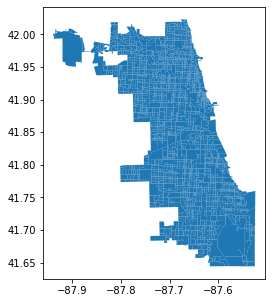

In [6]:
# Merge ACS data with Census block group boundaries 
merged_acs_gdf = gp.GeoDataFrame(census_bg_gdf.merge(acs_df, on="geo_12", how="inner"), 
                               crs=census_bg_gdf.crs)
merged_acs_gdf.plot()

In [7]:
merged_acs_gdf.head(2)

,geo_12,geometry,GEO_ID,Total Pop,White,Black,Median Income,Hispanic
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",1500000US170310101001,491,279,143,-666666666,90
1,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019...",1500000US170310101002,2197,766,1389,21222,127


In [8]:
merged_acs_gdf = merged_acs_gdf.drop(['GEO_ID'], axis=1)
# Replace -6666 with na
merged_acs_gdf['Median Income'] = np.where(merged_acs_gdf['Median Income'] < 0, np.nan, merged_acs_gdf['Median Income'])

In [9]:
#Calculate BG area
merged_acs_gdf['bg_area_km2'] = merged_acs_gdf.to_crs('EPSG:3857').area / 10**6

In [10]:
beats_gdf = gp.read_file('../data/geographies/Boundaries - Police Beats (current).geojson')

In [11]:
#Calculate Beat area
beats_gdf['beat_area_km2'] = beats_gdf.to_crs('EPSG:3857').area / 10**6

<AxesSubplot:>

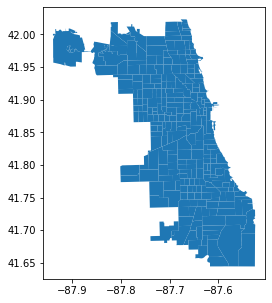

In [12]:
beats_gdf.plot()

In [13]:
beats_gdf.head(2)

,beat,beat_num,district,sector,geometry,beat_area_km2
0,1,1713,17,1,"MULTIPOLYGON (((-87.70473 41.97577, -87.70472 ...",2.122702
1,0,3100,31,0,"MULTIPOLYGON (((-87.83365 41.97535, -87.83366 ...",14.460490


In [14]:
# Ensure same projection
beats_gdf.crs = merged_acs_gdf.crs

In [15]:
#Merge data
from geopandas.tools import overlay
beats_acs_gdf = overlay(beats_gdf, merged_acs_gdf, how='union')

In [16]:
beats_acs_gdf.head(2)

,beat,beat_num,district,sector,beat_area_km2,geo_12,Total Pop,White,Black,Median Income,Hispanic,bg_area_km2,geometry
0,1,1713,17,1,2.122702,170310403003,849.0,550.0,25.0,112614.0,83.0,0.557031,"POLYGON ((-87.70473 41.97577, -87.70472 41.975..."
1,1,1911,19,1,4.135258,170310403003,849.0,550.0,25.0,112614.0,83.0,0.557031,"MULTIPOLYGON (((-87.70108 41.96851, -87.70108 ..."


In [17]:
# Drop if beat is NA
beats_acs_gdf = beats_acs_gdf.dropna(subset=['beat'])

In [18]:
# Confirm we have all beats
sum(beats_gdf.to_crs('EPSG:3857').area) - sum(beats_acs_gdf.to_crs('EPSG:3857').area)

0.4578096866607666

<AxesSubplot:>

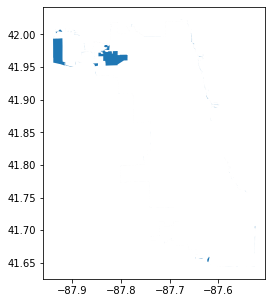

In [19]:
beats_acs_gdf[beats_acs_gdf['geo_12'].isnull()].plot()

## Create weighted average demographics

In [20]:
# 1. Calculate proportion of each block group in beat
beats_acs_gdf['beat_bg_area_km2'] = beats_acs_gdf.to_crs('EPSG:3857').area / 10**6
beats_acs_gdf['beat_bg_area_prop'] = beats_acs_gdf['beat_bg_area_km2'] / beats_acs_gdf['bg_area_km2']

In [21]:
beats_acs_gdf['beat_bg_area_prop'].describe()

count    4.947000e+03
mean     4.408854e-01
std      4.584503e-01
min      1.295894e-12
25%      5.203418e-05
50%      2.369157e-01
75%      9.998556e-01
max      1.000000e+00
Name: beat_bg_area_prop, dtype: float64

In [22]:
#2. Recalculate populations
for col in ['Total Pop', 'White', 'Black', 'Hispanic']:
    beats_acs_gdf[col] = beats_acs_gdf[col] * beats_acs_gdf['beat_bg_area_prop']

In [23]:
#3. Sum population by beat
beats_demo_gdf = beats_acs_gdf.groupby(['beat', 'beat_num', 'district', 'sector']).agg({'Total Pop': ['sum'],
                                                                       'White': ['sum'],
                                                                       'Black': ['sum'],
                                                                       'Hispanic': ['sum'],
                                                                       'Median Income': ['mean']})

In [24]:
#4. Calc percentages
for col in ['White', 'Black', 'Hispanic']:
    beats_demo_gdf[col] = beats_demo_gdf[col] / beats_demo_gdf['Total Pop']

In [25]:
# rename columns
beats_demo_gdf = beats_demo_gdf.reset_index()
beats_demo_gdf.columns = [col[0] for col in beats_demo_gdf.columns]

In [26]:
beats_demo_gdf[beats_demo_gdf['Median Income'].isnull()]

,beat,beat_num,district,sector,Total Pop,White,Black,Hispanic,Median Income
270,5,1651,16,5,0.0,NaN,NaN,NaN,NaN
271,5,1652,16,5,0.0,NaN,NaN,NaN,NaN
272,5,1653,16,5,0.0,NaN,NaN,NaN,NaN
274,5,1655,16,5,0.0,NaN,NaN,NaN,NaN


In [27]:
beats_demo_gdf

,beat,beat_num,district,sector,Total Pop,White,Black,Hispanic,Median Income
0,0,3100,31,0,739.498175,0.891204,0.075207,0.105740,70863.875000
1,1,0111,01,1,2303.898896,0.729601,0.039184,0.071100,98843.500000
2,1,0112,01,1,981.205008,0.686383,0.081220,0.092135,125252.333333
3,1,0113,01,1,951.687016,0.621650,0.103919,0.094872,121779.000000
4,1,0114,01,1,14944.268765,0.730854,0.057134,0.082221,118957.454545
...,...,...,...,...,...,...,...,...,...
270,5,1651,16,5,0.000000,NaN,NaN,NaN,NaN
271,5,1652,16,5,0.000000,NaN,NaN,NaN,NaN
272,5,1653,16,5,0.000000,NaN,NaN,NaN,NaN
273,5,1654,16,5,7354.836626,0.826988,0.026607,0.339339,60432.000000


In [28]:
# Assign median to NAs
beats_demo_gdf['Total Pop'] = np.where(beats_demo_gdf['Total Pop']==0, np.nan, beats_demo_gdf['Total Pop'])
beats_demo_gdf = beats_demo_gdf.fillna(beats_demo_gdf.median())
beats_demo_gdf

,beat,beat_num,district,sector,Total Pop,White,Black,Hispanic,Median Income
0,0,3100,31,0,739.498175,0.891204,0.075207,0.105740,70863.875000
1,1,0111,01,1,2303.898896,0.729601,0.039184,0.071100,98843.500000
2,1,0112,01,1,981.205008,0.686383,0.081220,0.092135,125252.333333
3,1,0113,01,1,951.687016,0.621650,0.103919,0.094872,121779.000000
4,1,0114,01,1,14944.268765,0.730854,0.057134,0.082221,118957.454545
...,...,...,...,...,...,...,...,...,...
270,5,1651,16,5,9173.222439,0.472633,0.239929,0.109303,46740.894737
271,5,1652,16,5,9173.222439,0.472633,0.239929,0.109303,46740.894737
272,5,1653,16,5,9173.222439,0.472633,0.239929,0.109303,46740.894737
273,5,1654,16,5,7354.836626,0.826988,0.026607,0.339339,60432.000000


In [30]:
#5. Export to csv
beats_demo_gdf.to_csv('../data/features/demographics.csv', index=False)

### Notes/further items
1. Currently taking straight average for median income
2. Several beat geograpies are not intersecting with census geographies.  Could re-download fuller census geographies for cook county.
3. Hispanic can be overlapping with white/black (note- not a change)